## 从细分到多层下钻数据分析
细分是网站分析的基本方法，也是数据分析的基本思路。细分分析的过程是对整体数据进行层层拆分，然后找到影响整体的局部因素。

图一

步骤1：全站流量按来源模块可细分为广告、SEM、SEO和直接输入（假设只有4个模块）。细分发现广告是网站流量的主要来源（昨日访问量占比82%），访问量增长2194，比例为67%，说明了广告是网站访问量增长的主要驱动因素。

步骤2：对广告模块做进一步细分，发现其中主要增长模块为Sina，该模块昨日访问量占比79%，环比前日增长1990，比例为85%。如果该模块有不同的位置，还可以做进一步细分。

至此已经找到了昨日网站访问量增长的主要原因是Sina来源流量增长，此时可直接找到Sina模块的业务负责人进行沟通进一步原因。

## 案例背景
日报、周报、月报等常规性报告是各个公司的基础数据支持形式。在日常报告中，经常会出现很多异常波动的指标，需要分析师找到异常波动的影响因素。但在寻找主要因素时由于需要下探的层级较多，实施起来会非常费时费力。以大型公司的广告投放渠道为例，可能包括以下层级：
+ 一级渠道包括SEM、AD、CPS、Social、导航等；
+ 二级渠道以SEM为基准包括百度、谷歌、360等；
+ 三级渠道以百度为基准包括关键字、网盟等；
+ 四级渠道以关键字为基准包括不同的广告计划；
+ 五级渠道以广告计划为基准可以细分到不同的广告组；
+ 六级渠道以广告组为基础可以细分到不同的关键字。

本案例介绍了一个自动化细分找到主要影响因素的方法——基于自动节点树的数据异常原因下探分析方法，该方法的实施思路是：找到每个层级上影响最大的因素并依次做下一因素的细分，直至最后一个因素。具体过程如下：
1. 统计全站在一定周期内、特定指标下的数据环比变化量和环比变化率。
1. 指定要分析日期并获得该日期及其前1天的数据。
1. 以全站数据为基准，下探第一层级维度并对指定日期和其前1天的数据做分类汇总。
1. 计算第一层级维度下分类汇总后的两天数据的差值并得到环比变化量和环比变化率。
1. 对第一层级维度下的变化量排序，并分别获得环比变化量最大和最小情况下的维度名称、变化量和变化率。
1. 计算下一层级变化量与上一层级变化量的比值，变化量最大值和最小值的比例将被定义为正向贡献率和负向贡献率。
1. 循环上述步骤，直至所有层级都计算完成。
1. 使用树形图展示所有层级下的变化量最大和最小的维度信息包括维度名称、环比变化量、环比变化率、贡献率等信息。

## 案例数据
以下是本数据集的6个维度的详细说明：
+ date：日期，格式是YYYY/MM/DD。
+ source：流量来源一级分类，来源于业务部门的定义。
+ site：流量来源二级分类，来源于业务部门的定义。
+ channel：流量来源三级分类，来源于业务部门的定义。
+ media：流量来源四级分类，来源于业务部门的定义。
+ visit：访问量。

In [24]:
import datetime
import pandas as pd
import numpy as np
from graphviz import Digraph  # 画图用库
# 载入数据
df = pd.read_csv('https://raw.githubusercontent.com/ffzs/dataset/master/advertising_data.csv')
# 显示部分数据
df.head()

,date,source,site,channel,media,visit
0,2017/5/15,品牌营销_品牌词,品牌词产品,播放器播放标签,PC,17600
1,2017/5/15,手机_品牌营销_品牌词,品牌词广告,15秒前贴片_app,app,15865
2,2017/5/15,SEO,百度,WAP,-,10858
3,2017/5/15,手机_品牌营销_品牌词,品牌词运营,移动端_乐见,app,9768
4,2017/5/15,SEO,百度,PC,-,9228


In [4]:
# 数据类型
df.dtypes

date       object
source     object
site       object
channel    object
media      object
visit      object
dtype: object

In [5]:
# 查看缺失值
df.isna().sum()

date       0
source     0
site       0
channel    0
media      0
visit      0
dtype: int64

根据上述的数据审车校验结果，需要处理的内容包括：
+ 将date列转换为日期型，便于后期基于数据做筛选以及日期计算。
+ 将visit列中的“-”进行转换。由于从网站分析工具导出时，“-”代表的是没有数据，因此这里转换为0。

In [6]:
# date列数据转化为日期型数据
df['date'] = df.date.astype('datetime64[ns]')
# 将visit列中的“-”转换为0
df['visit'] = df.visit.replace('-', 0).astype('int64')

这里先将每天的数据与其前1天的数据做环比变化统计。

In [8]:
# 获得每天visit的汇总
day_summary = df.iloc[:,-1].groupby(df.date).sum()
# 通过差分求平移一天后的变化
day_change_value = day_summary.diff(1).rename('change')
# 求变化率
day_change_rate = (day_change_value / day_summary).round(3).rename('change_rate')
# 合并
df_visit = pd.concat((day_summary, day_change_value, day_change_rate), axis=1) 
# 展示
df_visit.head()

,visit,change,change_rate
date,,,
2017-05-15,117260,NaN,NaN
2017-05-16,166124,48864.0,0.294
2017-05-17,157727,-8397.0,-0.053
2017-05-18,155805,-1922.0,-0.012
2017-05-19,115644,-40161.0,-0.347


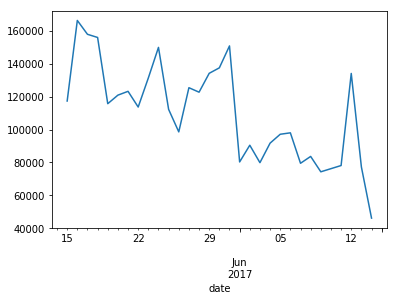

In [10]:
# 趋势观察
df_visit.visit.plot()

In [11]:
# 指定要分析的日期
the_day = pd.datetime(2017, 6, 7)
# 获取前一天日期
previous_day = the_day - datetime.timedelta(1) 
# 获取指定日期数据
the_day_tmp = df[df.date == the_day].rename(columns={'visit': the_day})
# 获取前一天数据
previous_day_tmp = df[df.date == previous_day].rename(columns={'visit': previous_day})
# 指定需要分析4个维度
dimension_list = df.columns.tolist()[1:-1]
# 每层分裂节点名称列表
split_node_list = ['全站']
# 每层分裂节点对应的总变化量
change_list = []
# 每层最大增长贡献最大的1个维度
increase_node_list = []
# 每层最小增长贡献最大的一个维度
decrease_node_list = []

In [14]:
# 遍历每一个维度
for dimension in dimension_list:
    # 获取指定日期的特定维度和访问量
    the_day_merge = the_day_tmp[[dimension, the_day]]
    # 获取前一天的特定维度和访问量
    previous_day_merge = previous_day_tmp[[dimension, previous_day]]

    # 对指定日期的特定维度汇总 
    the_day_groupby = the_day_merge.groupby(dimension).sum()
    # 对前一天的维度汇总
    previous_day_groupby = previous_day_merge.groupby(dimension).sum()

    # 讲两天的数据合并
    merge_data = the_day_groupby.join(previous_day_groupby, how='outer')

    # 将缺失值替换为0
    merge_data = merge_data.fillna(0)

    # 计算环比变化量
    merge_data['change'] = merge_data[the_day] - merge_data[previous_day]

    # 计算环比变化率
    merge_data['change_rate']  =  merge_data['change']  /  merge_data[previous_day]

    # 获取分裂节点的总变化值
    total_change = merge_data.change.sum()

    # 将变化值加入列表
    change_list.append(total_change)

    # 安环比变化量正向排序
    merge_data.sort_values('change', inplace=True)

    # 获得增长变化量最大节点名称
    max_increase_node = merge_data.index[-1]

    # 获得最大值节点变化量以及变化比例
    max_value, max_rate = merge_data.loc[max_increase_node][2:4] 

    # 将最大值信息追加到列表
    increase_node_list.append([max_increase_node,  int(max_value),  max_rate])   
    # 获得增长变化量最小值节点名称
    min_increase_node = merge_data.index[0]  
    # 获得最小值节点变化量以及变化比例
    min_value, min_rate = merge_data.loc[min_increase_node][2:4]  
    # 将最小值信息追加到列表
    decrease_node_list.append([min_increase_node,  int(min_value),  min_rate])

    # 判断增长方向
    if total_change >= 0:
        # 将分裂节点定义为增长最大值节点
        split_node_list.append(max_increase_node)
        # 通过分裂节点的个数判断所处分裂层级
        rules_len = len(split_node_list)
        # 按照相应的维度过滤出指定日期符合最大节点条件的数据
        the_day_tmp = the_day_tmp[the_day_tmp[dimension_list[rules_len-2]] == max_increase_node]
        # 按照相应的维度过滤出前一天符合最大节点条件的数据
        previous_day_tmp = previous_day_tmp[previous_day_tmp[dimension_list[rules_len-2]] == max_increase_node]    
    else:
        split_node_list.append(min_increase_node)
        # 通过分裂节点的个数判断所处分裂层级
        rules_len = len(split_node_list)
        # 按照相应的维度过滤出指定日期符合最大节点条件的数据
        the_day_tmp = the_day_tmp[the_day_tmp[dimension_list[rules_len-2]] == min_increase_node]
        # 按照相应的维度过滤出前一天符合最大节点条件的数据
        previous_day_tmp = previous_day_tmp[previous_day_tmp[dimension_list[rules_len-2]] == min_increase_node]

In [23]:
##### 作图 ####
node_style = {'fontname': "SimSun", 'shape': 'box'}  # 定义node节点样式
edge_style = {'fontname': "SimHei", 'fontsize': '11'}  # 定义edge节点样式
top_node_style = '<<table><tr><td bgcolor="black"><font color="white">{0}</font></td></tr><tr><td>环比变化量:{1:d}</td></tr><tr><td>环比变化率:{2:.0%}</td></tr></table>>'  # 定义顶部node节点标签样式
left_node_style = '<<table><tr><td bgcolor="chartreuse"><font color="black">{0}</font></td></tr><tr><td>环比变化量:{1}</td></tr><tr><td>环比变化率:{2:.0%}</td></tr></table>>'  # 定义左侧node节点标签样式
right_node_style = '<<table><tr><td bgcolor="lightblue"><font color="black">{0}</font></td></tr><tr><td>环比变化量:{1}</td></tr><tr><td>环比变化率:{2:.0%}</td></tr></table>>'  # 定义右侧node节点标签样式
dot = Digraph(format='png', node_attr=node_style, edge_attr=edge_style)  # 创建有向图


for i in range(4):  # 循环读取每一层
    node_name = split_node_list[i]  # 获得分裂节点名称
    node_left, max_value, max_rate = increase_node_list[i]  # 获得增长最大值名称、变化量和变化率
    node_right, min_value, min_rate = decrease_node_list[i]  # 获得增长最小值名称、变化量和变化率
    node_change = change_list[i]  # 获得分裂节点的总变化量-非分裂节点变化量
    node_label_left = left_node_style.format(node_left, max_value, max_rate)  # 左侧节点显示的信息
    node_label_right = right_node_style.format(node_right, min_value, min_rate)  # 右侧节点显示的信息
    if i == 0:  # 如果是顶部节点，则单独增加顶部节点信息
        day_data = df_visit[df_visit.index == the_day]  # 获得顶部节点的数据
        former_data = day_data.ix[0, 1]  # 获得全站总变化量
        node_lable = top_node_style.format(node_name, int(former_data), day_data.ix[0, 2])  # 分别获取顶部节点名称、变化量和变化率
        dot.node(node_name, label=node_lable)  # 增加顶部节点
    contribution_rate_1 = float(max_value) / former_data  # 获得左侧变化量贡献率
    contribution_rate_2 = float(min_value) / former_data  # 获得右侧变化量贡献率
    if node_change >= 0:  # 如果为增长，则左侧为正向
        edge_lablel_left = '正向贡献率:{0:.0%}'.format(contribution_rate_1)  # 左侧边的标签信息
        edge_lablel_right = '反向贡献率:{0:.0%}'.format(contribution_rate_2)  # 右侧边的标签信息
        former_data = max_value  # 获得上一层级变化量最大值
    else:  # 如果为下降，则右侧为正向
        edge_lablel_left = '反向贡献率:{0:.0%}'.format(contribution_rate_1)  # 左侧边的标签信息
        edge_lablel_right = '正向贡献率:{0:.0%}'.format(contribution_rate_2)  # 右侧边的标签信息
        former_data = min_value  # 获得上一层级变化量最大值
    dot.node(node_left, label=node_label_left)  # 增加左侧节点
    dot.node(node_right, label=node_label_right)  # 增加右侧节点
    dot.edge(node_name, node_left, label=edge_lablel_left, color='chartreuse')  # 增加左侧边
    dot.edge(node_name, node_right, label=edge_lablel_right, color='lightblue')  # 增加右侧边

dot.view('change summary')  # 展示图形结果



D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


'change summary.png'

## 结论
全站访问量下降18455，下降比例达到23%，主要的source源是CRM，其下降量为17591, “贡献”了95%的主要因素；而导致CRM下降的主要site源是准会员，其下降量为17575, “贡献了”几乎100%的下降因素；再进一步细分，在影响准会员的channel中，电视源的下降量达到19090, “贡献”了109%的比例，而导致电视流量下降的主要media源是APP，其贡献了19024的下降流量，比例几乎是100%。与此同时，某些来源渠道的流量与全站的下降趋势相反，呈现良好的增长趋势，这在全站的下降主要因子中表现良好，包括source源中的公众号流量环比增长2444，增长率达到171%; s准会员中的商城部分的流量增长1378，增长率为29%。

在上述结论中，针对每个节点（含分裂节点和非分裂节点）我们都有两个方向的参照：
+ 横向因子，即查询哪些特征对于上一层级的变化有主要的正向和负向贡献，这是贡献率的来源；
+ 纵向因子，即查询每个节点本身相对前1天的环比变化率，这是其本身随着时间的变化特征，能有效了解其自身波动水平。

## 补充

案例使用的graphviz是一个非常强大的用于展示复杂关系库。该库还有很多我们可以应用到的复杂场景，例如：

+ 基于网络转发的传播关系图；
+ 个人关系联络图；
+ 基于有时间序列的流程图；
+ 网络拓扑关系图；
+ 信息流和事件流图。

案例中分裂寻找的是变化量（也意味着变化率）最大的节点，如果有课题需要也可以将变化率或贡献度指定出来，在计算的时候按照指定的贡献率提取出一系列（而不是一个）因子。或者，可以依据业务手工分析的需求，沿着指定维度做层层下探，其实只是在维度循环时从预设维度变为根据系统选择传值而已。整个的实现思路，已经跟决策树的实现思想比较接近了，如果读者兴趣可以参照决策树的实现和优化思路。